In [1]:
pwd

'/home/jose/Desktop/Gitlab/hogan_lab/01_ESP/DMA_calibration'

# Reading results of SMPS

This script aims at reading and interpreting the results obtained by SMPS measurements.

In [2]:
# Rows info:
# 0 DAQ CV (V)
# 1 DMA HV (V)
# 2 Mobility (m2/s/V)
# 3 Mobility diameter (nm)
# 4 DMA-4136_220428172109.dat (#/cc)
# 5 current time (s)

In [3]:
k_B = 1.380650524e-23 # J/K
q_e = 1.602e-19       # C

In [4]:
from linker import *
%matplotlib notebook

In [5]:
import directDMA2py

In [6]:
def Open_data(filepath):
    dma_data = directDMA2py.dma(filepath)
    return dma_data

In [7]:
lines_results = [15, 41]
dma_data2 = Open_data("measurements/sabado-siluetas/pcl-dma_220507141211-new-psl-2.dat")
dma_data3 = Open_data("measurements/sabado-siluetas/pcl-dma_220507142338.dat")
dma_data4 = Open_data("measurements/sabado-siluetas/pcl-dma_220507141540-new-psl-4.dat")

dma_data3 = Open_data("measurements/sabado-siluetas/pcl-dma_220507114446.dat")
#dma_data4 = Open_data("measurements/sabado-siluetas/pcl-dma_220507111824.dat")
dma_data5 = Open_data("measurements/sabado-siluetas/pcl-dma_220507105048.dat")

<IPython.core.display.Javascript object>


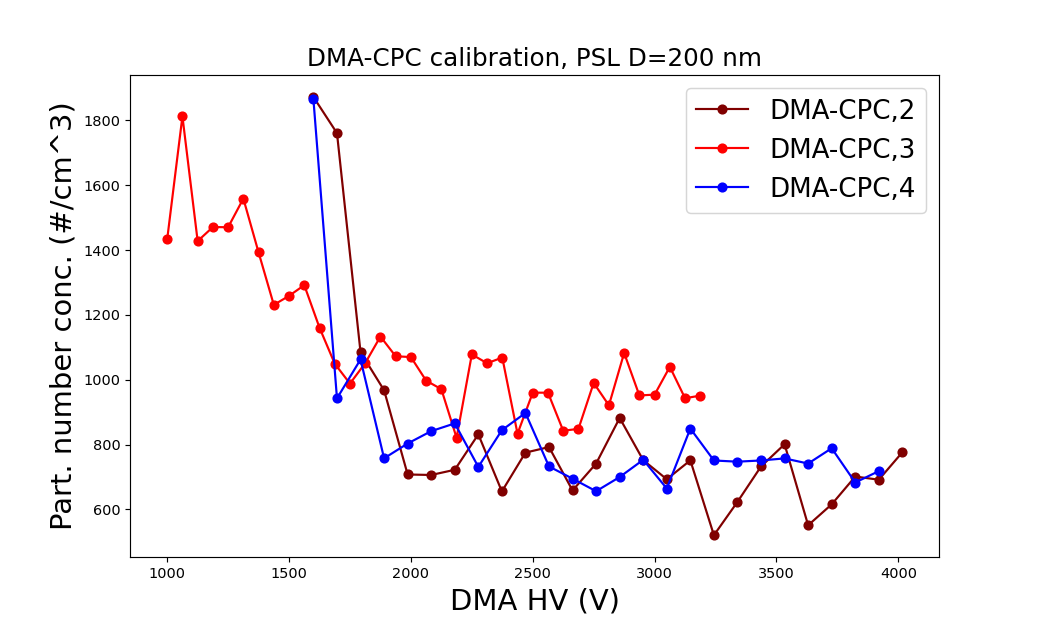

In [8]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17) 
title = "DMA-CPC calibration, PSL D=200 nm"
plt.title(title,fontsize=17)
ax1.plot(dma_data2.data.loc[1],dma_data2.data.loc[4],"o-",c="maroon",label="DMA-CPC,2")
ax1.plot(dma_data3.data.loc[1],dma_data3.data.loc[4],"o-",c="red",label="DMA-CPC,3")
ax1.plot(dma_data4.data.loc[1],dma_data4.data.loc[4],"o-",c="blue",label="DMA-CPC,4")
#plt.yscale("log")
ax1.set_xlabel('DMA HV (V)', fontsize=20)
ax1.set_ylabel('Part. number conc. (#/cm^3)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/DMA_CPC_voltage.png")

In [9]:
R1 = 9.37e-03         # m
R2 = 19.61e-03        # m
L = 44.369e-02        # m
A = L/np.log(R2/R1)

V = dma_data2.data.loc[1].values

sheath_flow = 6.7 # lpm
Z_pt = (2*sheath_flow * 1.66667e-5)/(4 * np.pi * A * V)

<IPython.core.display.Javascript object>


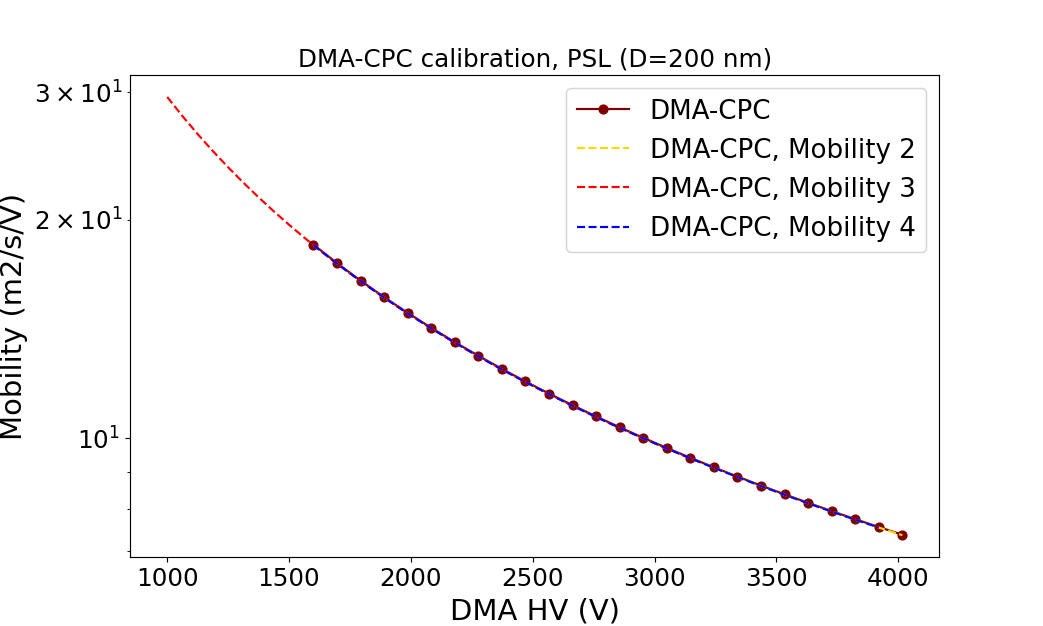

In [10]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17) 
title = "DMA-CPC calibration, PSL (D=200 nm)"
plt.title(title,fontsize=17)
ax1.plot(V,Z_pt*(1e+09),"o-",c="maroon",label="DMA-CPC")
ax1.plot(dma_data2.data.loc[1], dma_data2.data.loc[2]*(1e+09),"--",c="gold",label="DMA-CPC, Mobility 2")
ax1.plot(dma_data3.data.loc[1], dma_data3.data.loc[2]*(1e+09),"--",c="red",label="DMA-CPC, Mobility 3")
ax1.plot(dma_data4.data.loc[1], dma_data4.data.loc[2]*(1e+09),"--",c="blue",label="DMA-CPC, Mobility 4")
plt.yscale("log")
ax1.set_xlabel('DMA HV (V)', fontsize=20)
ax1.set_ylabel('Mobility (m2/s/V)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/DMA_mobility.png")

In [11]:
def Search_Dp(x):
    particle = Particle(x)
    return (particle["mobility"]-Z_pti)/Z_pti

def samesign(a, b):
        return a * b > 0

def bisect(func, low, high):
    'Find root of continuous function where f(low) and f(high) have opposite signs'

    assert not samesign(func(low), func(high))

    for i in range(54):
        midpoint = (low + high) / 2.0
        if samesign(func(low), func(midpoint)):
            low = midpoint
        else:
            high = midpoint

    return midpoint

In [12]:
# Gas dinamic viscosity
def Mu_gas(T_g):
    mu_g = (18.203E-6)*(293.15+110)/(T_g+110)*(T_g/293.15)**(1.5)
    return mu_g
# Gas mean free path
def Lambda_gas(T_g):
    P_g = 101300
    lambda_g = 66.5E-9*(101300/P_g)*(T_g/293.15)*(1+110/293.15)/(1+110/T_g)
    return lambda_g
# Gas Knudsen number
def GET_Cc(R,T_g):
    A1 = 1.142
    A2 = 0.558
    A3 = 0.999
    lambda_g = Lambda_gas(T_g)
    Kn = lambda_g/R
    return 1 + A1*Kn + A2*Kn*np.exp(-A3/Kn)
# Friction coefficient
def friction(Dp,T_g):
    mu_g = Mu_gas(T_g)
    Cc = GET_Cc(Dp*0.5,T_g)
    f =  3*np.pi*mu_g*Dp/Cc
    return f

def Particle(dp_new):
    q = 1
    f = friction(dp_new,T_g)
    particle = {"diameter": dp_new,
               "friction": f,
               "mobility": q*q_e/f}
    return particle

In [13]:
T_g = 300
Dp = np.zeros_like(Z_pt)

for i in range(len(Z_pt)):
    Z_pti = Z_pt[i]
    Dp[i] = bisect(Search_Dp, 1e-09, 1e-03)

In [14]:
from scipy.stats import norm

# PSL parameters
mean = 200
std = 5.3

Dp_vec = np.linspace(np.min(Dp),np.max(Dp),200)

norm = norm.pdf(Dp_vec * (1e+09), mean, std)
norm = norm/np.max(norm) * np.max(dma_data2.data.loc[4])

<IPython.core.display.Javascript object>


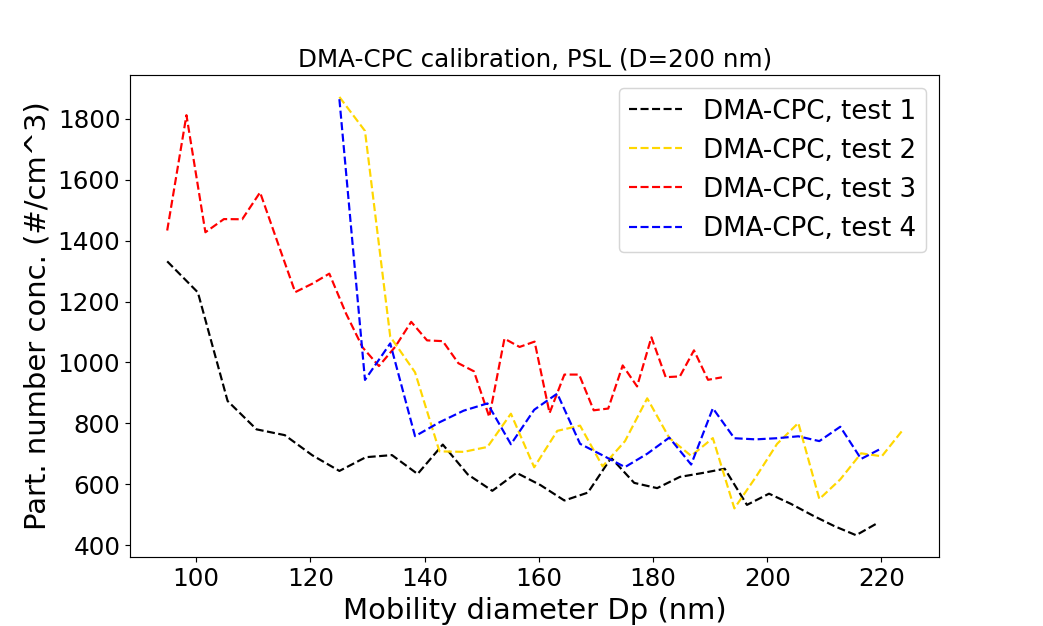

In [15]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17) 
title = "DMA-CPC calibration, PSL (D=200 nm)"
plt.title(title,fontsize=17)
#ax1.plot(Dp*(1e+09), dma_data2.data.loc[4],"o-",c="maroon",label="DMA-CPC")
ax1.plot(dma_data5.data.loc[3], dma_data5.data.loc[4],"--",c="black",label="DMA-CPC, test 1")
ax1.plot(dma_data2.data.loc[3], dma_data2.data.loc[4],"--",c="gold",label="DMA-CPC, test 2")
ax1.plot(dma_data3.data.loc[3], dma_data3.data.loc[4],"--",c="red",label="DMA-CPC, test 3")
ax1.plot(dma_data4.data.loc[3], dma_data4.data.loc[4],"--",c="blue",label="DMA-CPC, test 4")
#ax1.plot(Dp_vec*(1e+09), norm,"-",c="black",label="PSL")
#plt.yscale("log")
ax1.set_xlabel('Mobility diameter Dp (nm)', fontsize=20)
ax1.set_ylabel('Part. number conc. (#/cm^3)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/DMA_mobility.png")